Taken from
https://github.com/borisbanushev/stockpredictionai?source=post_page---------------------------

# 1. Introduction

Accurately predicting the stock markets is a complex task as there are millions of events and pre-conditions for a particilar stock to move in a particular direction. So we need to be able to capture as many of these pre-conditions as possible. We also need make several important assumptions: 1) markets are not 100% random, 2) history repeats, 3) markets follow people's rational behavior, and 4) the markets are 'perfect'. And, please, do read the Disclaimer at the bottom.

We will try to predict the price movements of Goldman Sachs (NYSE: GS). For the purpose, we will use daily closing price from January 1st, 2010 to December 31st, 2018 (seven years for training purposes and two years for validation purposes). We will use the terms 'Goldman Sachs' and 'GS' interchangeably.



# 2. The Data
We need to understand what affects whether GS's stock price will move up or down. It is what people as a whole think. Hence, we need to incorporate as much information (depicting the stock from different aspects and angles) as possible. (We will use daily data - 1,585 days to train the various algorithms (70% of the data we have) and predict the next 680 days (test data). Then we will compare the predicted results with a test (hold-out) data. Each type of data (we will refer to it as feature) is explained in greater detail in later sections, but, as a high level overview, the features we will use are:

1. Correlated assets - these are other assets (any type, not necessarily stocks, such as commodities, FX, indices, or even fixed income securities). A big company, such as Goldman Sachs, obviously doesn't 'live' in an isolated world - it depends on, and interacts with, many external factors, including its competitors, clients, the global economy, the geo-political situation, fiscal and monetary policies, access to capital, etc. The details are listed later.
2. Technical indicators - a lot of investors follow technical indicators. We will include the most popular indicators as independent features. Among them - 7 and 21 days moving average, exponential moving average, momentum, Bollinger bands, MACD.
3. Fundamental analysis - A very important feature indicating whether a stock might move up or down. There are two features that can be used in fundamental analysis: 1) Analysing the company performance using 10-K and 10-Q reports, analysing ROE and P/E, etc (we will not use this), and 2) News - potentially news can indicate upcoming events that can potentially move the stock in certain direction. We will read all daily news for Goldman Sachs and extract whether the total sentiment about Goldman Sachs on that day is positive, neutral, or negative (as a score from 0 to 1). As many investors closely read the news and make investment decisions based (partially of course) on news, there is a somewhat high chance that if, say, the news for Goldman Sachs today are extremely positive the stock will surge tomorrow. One crucial point, we will perform feature importance (meaning how indicative it is for the movement of GS) on absolutely every feature (including this one) later on and decide whether we will use it. More on that later.

  For the purpose of creating accurate sentiment prediction we will use Neural Language Processing (NLP). We will use BERT - Google's recently announced NLP approach for transfer learning for sentiment classification stock news sentiment extraction.


4. Fourier transforms - Along with the daily closing price, we will create Fourier transforms in order to generalize several long- and short-term trends. Using these transforms we will eliminate a lot of noise (random walks) and create approximations of the real stock movement. Having trend approximations can help the LSTM network pick its prediction trends more accurately.
5. Autoregressive Integrated Moving Average (ARIMA) - This was one of the most popular techniques for predicting future values of time series data (in the pre-neural networks ages). Let's add it and see if it comes off as an important predictive feature.
6. Stacked autoencoders - most of the aforementioned features (fundamental analysis, technical analysis, etc) were found by people after decades of research. But maybe we have missed something. Maybe there are hidden correlations that people cannot comprehend due to the enormous amount of data points, events, assets, charts, etc. With stacked autoencoders (type of neural networks) we can use the power of computers and probably find new types of features that affect stock movements. Even though we will not be able to understand these features in human language, we will use them in the GAN.
7. Deep Unsupervised learning for anomaly detection in options pricing. We will use one more feature - for every day we will add the price for 90-days call option on Goldman Sachs stock. Options pricing itself combines a lot of data. The price for options contract depends on the future value of the stock (analysts try to also predict the price in order to come up with the most accurate price for the call option). Using deep unsupervised learning (Self-organized Maps) we will try to spot anomalies in every day's pricing. Anomaly (such as a drastic change in pricing) might indicate an event that might be useful for the LSTM to learn the overall stock pattern.

Next, having so many features, we need to perform a couple of important steps:

1. Perform statistical checks for the 'quality' of the data. If the data we create is flawed, then no matter how sophisticated our algorithms are, the results will not be positive. The checks include making sure the data does not suffer from heteroskedasticity, multicollinearity, or serial correlation.
2. Create feature importance. If a feature (e.g. another stock or a technical indicator) has no explanatory power to the stock we want to predict, then there is no need for us to use it in the training of the neural nets. We will using XGBoost (eXtreme Gradient Boosting), a type of boosted tree regression algorithms.

As a final step of our data preparation, we will also create Eigen portfolios using Principal Component Analysis (PCA) in order to reduce the dimensionality of the features created from the autoencoders.

In [1]:
from utils import *

import pandas as pd
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

Note: The purpose of this section (3. The Data) is to show the data preprocessing and to give rationale for using different sources of data, hence I will only use a subset of the full data (that is used for training).

In [4]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [5]:
from alpha_vantage.timeseries import TimeSeries
key = 'BJUEJ3R9ZM8ER5KY'
ts = TimeSeries(key=key, output_format='pandas')

In [6]:
for i in np.arange(10):
    try:
        data, meta_data = ts.get_daily(symbol='GS', outputsize='full')
        break
    except:
        print('Attempt # {} failed'.format(str(i)))

In [7]:
dataset_base = pd.DataFrame({'Date':data.index,'GS':data['4. close']})
dataset_base['Date'] = [parser(x) for x in dataset_base['Date']]
dataset_base.head()

,Date,GS
date,,
1999-05-04,1999-05-04,70.38
1999-05-05,1999-05-05,69.13
1999-05-06,1999-05-06,67.94
1999-05-07,1999-05-07,74.13
1999-05-10,1999-05-10,70.69


In [8]:
print('There are {} number of days in the dataset.'.format(dataset_base.shape[0]))

There are 5090 number of days in the dataset.


In [9]:
dataset_base.to_csv('dataset_base.tsv', sep='\t', index=False)

Let's visualize the stock for the last nine years. The dashed vertical line represents the separation between training and test data.

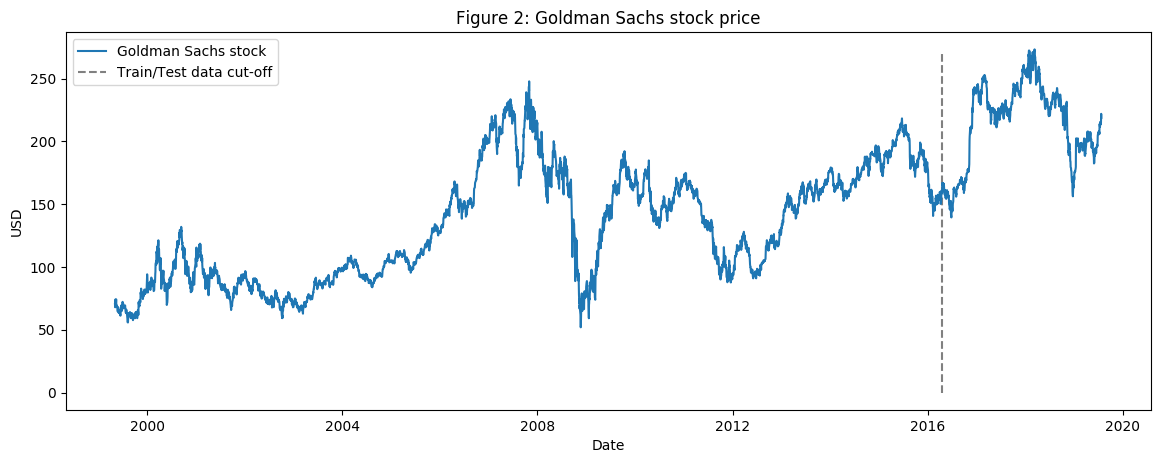

In [10]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_base['Date'], dataset_base['GS'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [11]:
num_training_days = int(dataset_base.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_base.shape[0]-num_training_days))


Number of training days: 3563. Number of test days: 1527.


# 3.1. Correlated assets
As explained earlier we will use other assets as features, not only GS.

So what other assets would affect GS's stock movements? Good understanding of the company, its lines of businesses, competitive landscape, dependencies, suppliers and client type, etc is very important for picking the right set of correlated assets:

* First are the companies similar to GS. We will add JPMorgan Chase and Morgan Stanley, among others, to the dataset.
* As an investment bank, Goldman Sachs depends on the global economy. Bad or volatile economy means no M&As or IPOs, and possibly limited proprietary trading earnings. That is why we will include global economy indices. Also, we will include LIBOR (USD and GBP denominated) rate, as possibly shocks in the economy might be accounted for by analysts to set these rates, and other FI securities.
* Daily volatility index (VIX) - for the reason described in the previous point.
* Composite indices - such as NASDAQ and NYSE (from USA), FTSE100 (UK), Nikkei225 (Japan), Hang Seng and BSE Sensex (APAC) indices.
* Currencies - global trade is many times reflected into how currencies move, ergo we'll use a basket of currencies (such as USDJPY, GBPUSD, etc) as features.

**Overall, we have 72 other assets in the dataset - daily price for every asset.**

In [12]:
tickers_corr = {'jpm':'JPM', 'ms':'MS', 'vix':'VIX', 'nasdaq':'NASDAQ:^IXIC', 'nya':'NYA',
               'usdjpy': 'USDJPY', 'gbpusd':'GBPUSD', 'usdeur':'USDEUR', 'nikkei':'^N225', 
                'sp500':'^GSPC', 'hangseng':'HSI'}

In [13]:
o = []
for i in tickers_corr.keys():
    for j in np.arange(30):
        try:
            temp, md = ts.get_daily(symbol=[tickers_corr[i]], outputsize='full')
            temp = temp[['4. close']]
            temp.columns = ['close']
            temp['type'] = i
            o.append(temp)
            break
        except:
            time.sleep(5)

o = pd.concat(o)
o['type'].value_counts()

gbpusd      5449
usdjpy      5449
ms          5425
jpm         5425
nikkei      4926
sp500       4921
nasdaq      4921
vix         4921
nya         4894
hangseng    4887
usdeur      4084
Name: type, dtype: int64

In [14]:
bad = list(set(o['type'].unique())-set(tickers_corr.keys()))
print(len(bad))

0


In [15]:
corr_assets = o.pivot_table(index=o.index, columns='type', values='close')
corr_assets.to_csv('correlated_assets.tsv', sep='\t', index=False)
corr_assets.head()

type,gbpusd,hangseng,jpm,ms,nasdaq,nikkei,nya,sp500,usdeur,usdjpy,vix
date,,,,,,,,,,,
1998-01-02,1.6405,NaN,110.62,58.75,NaN,NaN,NaN,NaN,NaN,132.32,NaN
1998-01-05,1.6380,NaN,112.44,60.88,NaN,NaN,NaN,NaN,NaN,133.88,NaN
1998-01-06,1.6327,NaN,107.19,60.00,NaN,NaN,NaN,NaN,NaN,133.53,NaN
1998-01-07,1.6242,NaN,108.38,58.50,NaN,NaN,NaN,NaN,NaN,132.07,NaN
1998-01-08,1.6155,NaN,104.19,58.94,NaN,NaN,NaN,NaN,NaN,132.55,NaN


# 3.2. Technical indicators
We already covered what are technical indicators and why we use them so let's jump straight to the code. We will create technical indicators only for GS.

In [16]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7, min_periods=1).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21, min_periods=1).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['price'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['price'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
    dataset['20sd'] = dataset['price'].rolling(20, min_periods=0).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset

In [17]:
dataset_base['price'] = dataset_base['GS']
technical_indicators = get_technical_indicators(dataset_base[['price']])
technical_indicators.head()

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
date,,,,,,,,,,,,
1999-05-04,70.38,70.380,70.380,70.380000,70.380000,0.000000,NaN,NaN,NaN,70.380000,69.38,4.239599
1999-05-05,69.13,69.755,69.755,70.287407,70.187692,-0.099715,0.883883,71.522767,67.987233,69.442500,68.13,4.221418
1999-05-06,67.94,69.150,69.150,70.113525,69.841893,-0.271632,1.220123,71.590246,66.709754,68.402308,66.94,4.203797
1999-05-07,74.13,70.395,70.395,70.411042,70.501602,0.090560,2.681896,75.758792,65.031208,72.268500,73.13,4.292239
1999-05-10,70.69,70.454,70.454,70.431706,70.530586,0.098881,2.326334,75.106668,65.801332,71.211818,69.69,4.244057


So we have the technical indicators (including MACD, Bollinger bands, etc) for every trading day. We have in total 12 technical indicators.

Let's visualize the last 400 days of these indicators.

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, 0, last_days, colors='g', linestyles='--')
    plt.hlines(-15, 0, last_days, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

In [ ]:
plot_technical_indicators(technical_indicators, 400)

## 3.3. Fundamental analysis
For fundamental analysis we will perform sentiment analysis on all daily news about GS. Using sigmoid at the end, result will be between 0 and 1. The closer the score is to 0 - the more negative the news is (closer to 1 indicates positive sentiment). For each day, we will create the average daily score (as a number between 0 and 1) and add it as a feature.

### 3.3.1. Bidirectional Embedding Representations from Transformers - BERT
For the purpose of classifying news as positive or negative (or neutral) we will use BERT, which is a pre-trained language representation.

Pretrained BERT models are already available in MXNet/Gluon. We just need to instantiated them and add two (arbitrary number) Dense layers, going to softmax - the score is from 0 to 1.

In [ ]:
# just import bert
import bert

In [ ]:
import json, requests

In [ ]:
q = 'https://stocknewsapi.com/api/v1?tickers=GS&items=50&token=vteixkw9an9ggtxuv54gqqrptqmx5fxoxtct73vs'
r = requests.get(q)

In [ ]:
r.content

In [ ]:
j = r.json()
j

In [ ]:
o = []
for i in j['data']:
    oo = {'title':i['title'],'text':i['text'], 'date':i['date'], 'sentiment':i['sentiment']}
    o.append(oo)
    
o = pd.DataFrame(o)
o.to_csv('train_data_50_rows.tsv', sep='\t', index=False)
o

Going into the details of BERT and the NLP part is not in the scope of this notebook, but you have interest, do let me know - I will create a new repo only for BERT as it definitely is quite promissing when it comes to language processing tasks.

## 3.4. Fourier transforms for trend analysis
Fourier transforms take a function and create a series of sine waves (with different amplitudes and frames). When combined, these sine waves approximate the original function. Mathematically speaking, the transforms look like this:

$$G(f) = \int_{-\infty}^\infty g(t) e^{-i 2 \pi f t} dt$$

We will use Fourier transforms to extract global and local trends in the GS stock, and to also denoise it a little. So let's see how it works.

In [ ]:
data_FT = dataset_ex_df[['Date', 'GS']]

In [ ]:
close_fft = np.fft.fft(np.asarray(data_FT['GS'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

In [ ]:
plt.figure(figsize=(14, 7))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['GS'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

As you see in Figure 3 the more components from the Fourier transform we use the closer the approximation function is to the real stock price (the 100 components transform is almost identical to the original function - the red and the purple lines almost overlap). We use Fourier transforms for the purpose of extracting long- and short-term trends so we will use the transforms with 3, 6, and 9 components. You can infer that the transform with 3 components serves as the long term trend.

Another technique used to denoise data is call wavelets. Wavelets and Fourier transform gave similar results so we will only use Fourier transforms.

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## 3.5. ARIMA as a feature
ARIMA is a technique for predicting time series data. We will show how to use it, and althouth ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['GS']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real', linestyle='--')
plt.plot(predictions, color='red', label='Predicted', linestyle='--')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM because, as we mentioned before, we want to capture as many features and patterns about Goldman Sachs as possible. We go test MSE (mean squared error) of 10.151, which by itself is not a bad result (considering we do have a lot of test data), but still we will only use it as a feature in the LSTM.

# 3.6. Statistical checks
Ensuring that the data has good quality is very important for out models. In order to make sure our data is suitable we will perform a couple of simple checks in order to ensure that the results we achieve and observe are indeed real, rather than compromised due to the fact that the underlying data distribution suffers from fundamental errors.

## 3.6.1. Heteroskedasticity, multicollinearity, serial correlation
Conditional Heteroskedasticity occurs when the error terms (the difference between a predicted value by a regression and the real value) are dependent on the data - for example, the error terms grow when the data point (along the x-axis) grow.
Multicollinearity is when error terms (also called residuals) depend on each other.
Serial correlation is when one data (feature) is a formula (or completely depemnds) of another feature.
We will not go into the code here as it is straightforward and our focus is more on the deep learning parts, but the data is qualitative.

# 3.7. Feature Engineering

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

So, after adding all types of data (the correlated assets, technical indicators, fundamental analysis, Fourier, and Arima) we have a total of 112 features for the 2,265 days (as mentioned before, however, only 1,585 days are for training data).

We will also have some more features generated from the autoencoders.

### 3.7.1. Feature importance with XGBoost
Having so many features we have to consider whether all of them are really indicative of the direction GS stock will take. For example, we included USD denominated LIBOR rates in the dataset because we think that changes in LIBOR might indicate changes in the economy, that, in turn, might indicate changes in the GS's stock behavior. But we need to test. There are many ways to test feature importance, but the one we will apply uses XGBoost, because it gives one of the best results in both classification and regression problems.

Since the features dataset is quite large, for the purpose of presentation here we'll use only the technical indicators. During the real features importance testing all selected features proved somewhat important so we won't exclude anything when training the GAN.

In [ ]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['price']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [ ]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [ ]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

Let's plot the training and validation errors in order to observe the training and check for overfitting (there isn't overfitting).

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

Not surprisingly (for those with experience in stock trading) that MA7, MACD, and BB are among the important features.

I followed the same logic for performing feature importance over the whole dataset - just the training took longer and results were a little more difficult to read, as compared with just a handful of features.

## 3.8. Extracting high-level features with Stacked Autoencoders
Before we proceed to the autoencoders, we'll explore an alternative activation function.

### 3.8.1. Activation function - GELU (Gaussian Error)
GELU - Gaussian Error Linear Unites was recently proposed - link. In the paper the authors show several instances in which neural networks using GELU outperform networks using ReLU as an activation. gelu is also used in BERT, the NLP approach we used for news sentiment analysis.

We will use GELU for the autoencoders.

Note: The cell below shows the logic behind the math of GELU. It is not the actual implementation as an activation function. I had to implement GELU inside MXNet. If you follow the code and change act_type='relu' to act_type='gelu' it will not work, unless you change the implementation of MXNet. Make a pull request on the whole project to access the MXNet implementation of GELU.

In [ ]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

Let's visualize GELU, ReLU, and LeakyReLU (the last one is mainly used in GANs - we also use it).

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

Note: In future versions of this notebook I will experiment using U-Net (link), and try to utilize the convolutional layer and extract (and create) even more features about the stock's underlying movement patterns. For now, we will just use a simple autoencoder made only from Dense layers.

Ok, back to the autoencoders, depicted below (the image is only schematic, it doesn't represent the real number of layers, units, etc.)

Note: One thing that I will explore in a later version is removing the last layer in the decoder. Normally, in autoencoders the number of encoders == number of decoders. We want, however, to extract higher level features (rather than creating the same input), so we can skip the last layer in the decoder. We achieve this creating the encoder and decoder with same number of layers during the training, but when we create the output we use the layer next to the only one as it would contain the higher level features.

https://github.com/borisbanushev/stockpredictionai/raw/master/imgs/VAE.jpg

In [ ]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [ ]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [ ]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='gelu')

In [ ]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [ ]:
print(net)

In [ ]:
So we have 3 layers (with 400 neurons in each) in both the encoder and the decoder.

In [ ]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

In [ ]:
dataset_total_df['Date'] = dataset_ex_df['Date']

In [ ]:
vae_added_df = mx.nd.array(dataset_total_df.iloc[:, :-1].values)

In [ ]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

We created 112 more features from the autoencoder. As we want to only have high level features (overall patterns) we will create an Eigen portfolio on the newly created 112 features using Principal Component Analysis (PCA). This will reduce the dimension (number of columns) of the data. The descriptive capability of the Eigen portfolio will be the same as the original 112 features.

Note Once again, this is purely experimental. I am not 100% sure the described logic will hold. As everything else in AI and deep learning, this is art and needs experiments.

### 3.8.2. Eigen portfolio with PCA

In [ ]:
# We want the PCA to create the new components to explain 80% of the variance
pca = PCA(n_components=.8)

In [ ]:
x_pca = StandardScaler().fit_transform(vae_added_df)

In [ ]:
principalComponents = pca.fit_transform(x_pca)

In [ ]:
principalComponents.n_components_

So, in order to explain 80% of the variance we need 84 (out of the 112) features. This is still a lot. So, for now we will not include the autoencoder created features. I will work on creating the autoencoder architecture in which we get the output from an intermediate layer (not the last one) and connect it to another Dense layer with, say, 30 neurons. Thus, we will 1) only extract higher level features, and 2) come up with significantly fewer number of columns.

## 3.9. Deep Unsupervised Learning for anomaly detection in derivatives pricing
-- To be added soon.

# 4. Generative Adversarial Network (GAN)

How GANs work?

As mentioned before, the purpose of this notebook is not to explain in detail the math behind deep learning but to show its applications. Of course, thorough and very solid understanding from the fundamentals down to the smallest details, in my opinion, is extremely imperative. Hence, we will try to balance and give a high-level overview of how GANs work in order for the reader to fully understand the rationale behind using GANs in predicting stock price movements. Feel free to skip this and the next section if you are experienced with GANs (and do check section 4.2.).

A GAN network consists of two models - a Generator ($G$) and Discriminator ($D$). The steps in training a GAN are:

1. The Generator is, using random data (noise denoted $z$), trying to 'generate' data indistinguishable of, or extremely close to, the real data. It's purpose is to learn the distribution of the real data.
2. Randomly, real or generated data is fitted into the Discriminator, which acts as a classifier and tries to understand whether the data is coming from the Generator or is the real data. $D$ estimates the (distributions) probabilities of the incoming sample to the real dataset. (more info on comparing two distributions in section 4.2. below).
3. Then, the losses from $G$ and $D$ are combined and propagated back through the generator. Ergo, the generator's loss depends on both the generator and the discriminator. This is the step that helps the Generator learn about the real data distribution. If the generator doesn't do a good job at generating a realistic data (having the same distribution), the Discriminator's work will be very easy to distinguish generated from real data sets. Hence, the Discriminator's loss will be very small. Small discriminator loss will result in bigger generator loss (see the equation below for $L(D, G)$). This makes creating the discriminator a bit tricky, because too good of a discriminator will always result in a huge generator loss, making the generator unable to learn.
4. The process goes on until the Discriminator can no longer distinguish generated from real data.

When combined together, $D$ and $G$ as sort of playing a minmax game (the Generator is trying to fool the Discriminator making it increase the probability for on fake examples, i.e. minimize $\mathbb{E}{z \sim p{z}(z)} [\log (1 - D(G(z)))]$. The Discriminator wants to separate the data coming from the Generator, $D(G(z))$, by maximizing $\mathbb{E}{x \sim p{r}(x)} [\log D(x)]$). Having separated loss functions, however, it is not clear how both can converge together (that is why we use some advancements over the plain GANs, such as Wasserstein GAN). Overall, the combined loss function looks like:

$$L(D, G) = \mathbb{E}{x \sim p{r}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log(1 - D(G(z)))]$$

Note: Really useful tips for training GANs can be found here.

Note: I will not include the complete code behind the GAN and the Reinforcement learning parts in this notebook - only the results from the execution (the cell outputs) will be shown. Make a pull request or contact me for the code.

## 4.1. Why GAN for stock market prediction?
Generative Adversarial Networks (GAN) have been recently used mainly in creating realistic images, paintings, and video clips. There aren't many applications of GANs being used for predicting time-series data as in our case. The main idea, however, should be same - we want to predict future stock movements. In the future, the pattern and behavior of GS's stock should be more or less the same (unless it starts operating in a totally different way, or the economy drastically changes). Hence, we want to 'generate' data for the future that will have similar (not absolutely the same, of course) distribution as the one we already have - the historical trading data. So, in theory, it should work.

In our case, we will use LSTM as a time-series generator, and CNN as a discriminator.

## 4.2. Metropolis-Hastings GAN and Wasserstein GAN
Note: The next couple of sections assume some experience with GANs.

**I. Metropolis-Hastings GAN**
A recent improvement over the traditional GANs came out from Uber's engineering team and is called Metropolis-Hastings GAN (MHGAN). The idea behind Uber's approach is (as they state it) somewhat similar to another approach created by Google and University of California, Berkeley called Discriminator Rejection Sampling (DRS). Basically, when we train GAN we use the Discriminator ($D$) for the sole purpose of better training the Generator ($G$). Often, after training the GAN we do not use the $D$ any more. MHGAN and DRS, however, try to use $D$ in order to choose samples generated by $G$ that are close to the real data distribution (slight difference between is that MHGAN uses Markov Chain Monte Carlo (MCMC) for sampling).

MHGAN takes K samples generated from the $G$ (created from independent noise inputs to the $G$ - $z_0$ to $z_K$ in the figure below). Then it sequentially runs through the K outputs ($x'_0$ to $x'_K$) and following an acceptance rule (created from the Discriminator) decides whether to accept the current sample or keep the last accepted one. The last kept output is the one considered the real output of $G$.

Note: MHGAN is originally implemented by Uber in pytorch. I only transferred it into MXNet/Gluon.

Note: I will also upload it into Github sometime soon.


Figure 10: Visual representation of MHGAN (from the original Uber post).
https://eng.uber.com/mh-gan/?amp

**II. Wasserstein GAN**
Training GANs is quite difficult. Models may never converge and mode collapse can easily happen. We will use a modification of GAN called Wasserstein GAN - WGAN.

Again, we will not go into details, but the most notable points to make are:

* As we know the main goal behind GANs is for the Generator to start transforming random noise into some given data that we want to mimic. Ergo, the idea of comparing the similarity between two distributions is very imperative in GANs. The two most widely used such metrics are:
    * KL divergence (Kullback–Leibler) - $D_{KL}(p | q) = \int_x p(x) \log \frac{p(x)}{q(x)} dx$. $D_{KL}$ is zero when $p(x)$ is equal to $q(x)$,
    *JS Divergence (Jensen–Shannon) - $D_{JS}(p | q) = \frac{1}{2} D_{KL}(p | \frac{p + q}{2}) + \frac{1}{2} D_{KL}(q | \frac{p + q}{2})$. JS divergence is bounded by 0 and 1, and, unlike KL divergence, is symmetric and smoother. Significant success in GAN training was achieved when the loss was switched from KL to JS divergence.
* WGAN uses Wasserstein distance, $W(p_r, p_g) = \frac{1}{K} \sup_{| f |L \leq K} \mathbb{E}{x \sim p_r}[f(x)] - \mathbb{E}_{x \sim p_g}[f(x)]$ (where $sup$ stands for supremum), as a loss function (also called Earth Mover's distance, because it normally is interpreted as moving one pile of, say, sand to another one, both piles having different probability distributions, using minimum energy during the transformation). Compared to KL and JS divergences, Wasserstein metric gives a smooth measure (without sudden jumps in divergence). This makes it much more suitable for creating a stable learning process during the gradient descent.
* Also, compared to KL and JS, Wasserstein distance is differentiable nearly everywhere. As we know, during backpropagation, we differentiate the loss function in order to create the gradients, which in turn update the weights. Therefore, having a differentiable loss function is quite important.

Hands down, this was the toughest part of this notebook. Mixing WGAN and MHGAN took me three days.

## 4.4. The Generator - One layer RNN

### 4.4.1. LSTM or GRU

As mentioned before, the generator is a LSTM network a type of Recurrent Neural Network (RNN). RNNs are used for time-series data because because they keep track of all previous data points and can capture patterns developing through time. Due to their nature, RNNs many time suffer from vanishing gradient - that is, the changes the weights receive during training become so small, that they don't change, making the network unable to converge to a minimal loss (The opposite problem can also be observed at times - when gradients become too big. This is called gradient exploding, but the solution to this is quite simple - clip gradients if they start exceeding some constant number, i.e. gradient clipping). Two modifications tackle this problem - Gated Recurrent Unit (GRU) and Long-Short Term Memory (LSTM). The biggest differences between the two are: 1) GRU has 2 gates (update and reset) and LSTM has 4 (update, input, forget, and output), 2) LSTM maintains an internal memory state, while GRU doesn’t, and 3) LSTM applies a nonlinearity (sigmoid) before the output gate, GRU doesn’t.

In most cases LSTM and GRU give similar results in terms of accuracy but GRU is much less computational intensive, as GRU has much fewer trainable params. LSTMs, however, and much more used.

Strictly speaking, the math behind the LSTM cell (the gates) is:

$$g_t = \text{tanh}(X_t W_{xg} + h_{t-1} W_{hg} + b_g),$$

$$i_t = \sigma(X_t W_{xi} + h_{t-1} W_{hi} + b_i),$$

$$f_t = \sigma(X_t W_{xf} + h_{t-1} W_{hf} + b_f),$$

$$o_t = \sigma(X_t W_{xo} + h_{t-1} W_{ho} + b_o),$$

$$c_t = f_t \odot c_{t-1} + i_t \odot g_t,$$

$$h_t = o_t \odot \text{tanh}(c_t),$$

where $\odot$ is an element-wise multiplication operator, and, for all $x = [x_1, x_2, \ldots, x_k]^\top \in R^k$ the two activation functions:,

$$\sigma(x) = \left[\frac{1}{1+\exp(-x_1)}, \ldots, \frac{1}{1+\exp(-x_k)}]\right]^\top,$$

$$\text{tanh}(x) = \left[\frac{1-\exp(-2x_1)}{1+\exp(-2x_1)}, \ldots, \frac{1-\exp(-2x_k)}{1+\exp(-2x_k)}\right]^\top$$

### 4.4.2. The LSTM architecture
       
The LSTM architecture is very simple - one LSTM layer with 112 input units (as we have 112 features in the dataset) and 500 hidden units, and one Dense layer with 1 output - the price for every day. The initializer is Xavier and we will use L1 loss (which is mean absolute error loss with L1 regularization - see section 4.4.5. for more info on regularization).

Note - In the code you can see we use Adam (with learning rate of .01) as an optimizer. Don't pay too much attention on that now - there is a section specially dedicated to explain what hyperparameters we use (learning rate is excluded as we have learning rate scheduler - section 4.4.3.) and how we optimize these hyperparameters - section 4.6.

In [ ]:
gan_num_features = dataset_total_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')
            
            self.decoder = nn.Dense(1, in_units=num_hidden)
    
    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)
    
lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()

We will use 500 neurons in the LSTM layer and use Xavier initialization. For regularization we'll use L1. Let's see what's inside the LSTM as printed by MXNet.

In [ ]:
print(lstm_model)

In [ ]:
RNNModel(
  (rnn): LSTM(112 -> 500, TNC)
  (decoder): Dense(500 -> 1, linear)
)

As we can see, the input of the LSTM are the 112 features (dataset_total_df.shape[1]) which then go into 500 neurons in the LSTM layer, and then transformed to a single output - the stock price value.

The logic behind the LSTM is: we take 17 (sequence_length) days of data (again, the data being the stock price for GS stock every day + all the other feature for that day - correlated assets, sentiment, etc.) and try to predict the 18th day.

In another post I will explore whether modification over the vanilla LSTM would be more beneficial, such as:

* using bidirectional LSTM layer - in theory, going backwards (from end of the data set towards the beginning) might somehow help the LSTM figure out the pattern of the stock movement.
* using stacked RNN architecture - having not only one LSTM layer but 2 or more. This, however, might be dangerous, as we might end up overfitting the model, as we don't have a lot of data (we have just 1,585 day worth of data).
* Exploring GRU - as already explained, GRUs' cells are much more simpler.
* Adding attention vectors to the RNN.

### 4.4.3. Learning rate scheduler

One of the most important hyperparameters is the learning rate. Setting the learning rate for almost every optimizer (such as SGD, Adam, or RMSProp) is crucially important when training neural networks because it controls both the speed of convergence and the ultimate performance of the network. One of the simplest learning rate strategies is to have a fixed learning rate throughout the training process. Choosing a small learning rate allows the optimizer find good solutions, but this comes at the expense of limiting the initial speed of convergence. Changing the learning rate over time can overcome this tradeoff.

Recent papers, such as this, show the benefits of changing the global learning rate during training, in terms of both convergence and time.

In [ ]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

In [ ]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
iterations=1500

plt.plot([i+1 for i in range(iterations)],[schedule(i) for i in range(iterations)])
plt.title('Learning rate for each epoch')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

### 4.4.4. How to prevent overfitting and the bias-variance trade-off

Having a lot of features and neural networks we need to make sure we prevent overfitting and be mindful of the total loss.

We use several techniques for preventing overfitting (not only in the LSTM, but also in the CNN and the auto-encoders):

* Ensuring data quality. We already performed statistical checks and made sure the data doesn't suffer from multicollinearity or serial autocorrelation. Further we performed feature importance check on each feature. Finally, the initial feature selection (e.g. selecting correlated assets, technical indicators, etc.) was done with some domain knowledge about the mechanics behind the way stock markets work.
* Regularization (or weights penalty). The two most widely used regularization techniques are LASSO (L1) and Ridge (L2). L1 adds the mean absolute error and L2 adds mean squared error to the loss. Without going into too many mathematical details, the basic differences are: lasso regression (L1) does both variable selection and parameter shrinkage, whereas Ridge regression only does parameter shrinkage and end up including all the coefficients in the model. In presence of correlated variables, ridge regression might be the preferred choice. Also, ridge regression works best in situations where the least square estimates have higher variance. Therefore, it depends on our model objective. The impact of the two types of regularizations is quite different. While they both penalize large weights, L1 regularization leads to a non-differentiable function at zero. L2 regularization favors smaller weights, but L1 regularization favors weights that go to zero. So, with L1 regularization you can end up with a sparse model - one with fewer parameters. In both cases the parameters of the L1 and L2 regularized models "shrink", but in the case of L1 regularization the shrinkage directly impacts the complexity (the number of parameters) of the model. Precisely, ridge regression works best in situations where the least square estimates have higher variance. L1 is more robust to outliers, is used when data is sparse, and creates feature importance. We will use L1.
* Dropout. Dropout layers randomly remove nodes in the hidden layers.
* Dense-sparse-dense training. - link
* Early stopping.

Another important consideration when building complex neural networks is the bias-variance trade-off. Basically, the error we get when training nets is a function of the bias, the variance, and irreducible error - σ (error due to noise and randomness). The simplest formula of the trade-off is:

$$Error = bias^{2} + variance + \sigma$$

* Bias. Bias measures how well a trained (on training dataset) algorithm can generalize on unseen data. High bias (underfitting) meaning the model cannot work well on unseen data.
* Variance. Variance measures the sensitivity of the model to changes in the dataset. High variance is the overfitting.

### 4.4.5. Custom weights initializers and custom loss metric
Coming soon

## 4.5. The Discriminator - One Dimentional CNN
### 4.5.1. Why CNN as a discriminator?

We usually use CNNs for work related to images (classification, context extraction, etc). They are very powerful at extracting features from features from features, etc. For example, in an image of a dog, the first convolutional layer will detect edges, the second will start detecting circles, and the third will detect a nose. In our case, data points form small trends, small trends form bigger, trends in turn form patterns. CNNs' ability to detect features can be used for extracting information about patterns in GS's stock price movements.

Another reason for using CNN is that CNNs work well on spatial data - meaning data points that are closer to each other are more related to each other, than data points spread across. This should hold true for time series data. In our case each data point (for each feature) is for each consecutive day. It is natural to assume that the closer two days are to each other, the more related they are to each other. One thing to consider (although not covered in this work) is seasonality and how it might change (if at all) the work of the CNN.

Note: As many other parts in this notebook, using CNN for time series data is experimental. We will inspect the results, without providing mathematical or other proofs. And results might vary using different data, activation functions, etc.

### 4.5.1. The CNN Architecture
Figure 11: High level overview of the CNN architecture.

The code for the CNN inside the GAN looks like this:

In [ ]:
num_fc = 512

# ... other parts of the GAN

cnn_net = gluon.nn.Sequential()
with net.name_scope():
    
    # Add the 1D Convolutional layers
    cnn_net.add(gluon.nn.Conv1D(32, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(gluon.nn.Conv1D(64, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    cnn_net.add(gluon.nn.Conv1D(128, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    
    # Add the two Fully Connected layers
    cnn_net.add(nn.Dense(220, use_bias=False), nn.BatchNorm(), nn.LeakyReLU(0.01))
    cnn_net.add(nn.Dense(220, use_bias=False), nn.Activation(activation='relu'))
    cnn_net.add(nn.Dense(1))
    
# ... other parts of the GAN

Let's print the CNN.

In [ ]:
print(cnn_net)

## 4.6. Hyperparameters

The hyperparameters that we will track and optimize are:

* batch_size : batch size of the LSTM and CNN
* cnn_lr: the learningrate of the CNN
* strides: the number of strides in the CNN
* lrelu_alpha: the alpha for the LeakyReLU in the GAN
* batchnorm_momentum: momentum for the batch normalisation in the CNN
* padding: the padding in the CNN
* kernel_size':1: kernel size in the CNN
* dropout: dropout in the LSTM
* filters: the initial number of filters

We will train over 200 epochs.

In [ ]:
5. Hyperparameters optimization
       After the GAN trains on the 200 epochs it will record the MAE (which is the error function in the LSTM, the $G$) and pass it as a reward value to the Reinforcement learning that will decide whether to change the hyperparameters of keep training with the same set of hyperparameters. As described later, this approach is strictly for experimenting with RL.

       If the RL decides it will update the hyperparameters it will call Bayesian optimisation (discussed below) library that will give the next best expected set of the hyperparams.

5.1. Reinforcement learning for hyperparameters optimization
       Why do we use reinforcement learning in the hyperparameters optimization? Stock markets change all the time. Even if we manage to train our GAN and LSTM to create extremely accurate results, the results might only be valid for a certain period. Meaning, we need to constantly optimise the whole process. To optimize the process we can:

Add or remove features (e.g. add new stocks or currencies that might be correlated)
Improve the our deep learning models. One of the most important ways to improve the models is through the hyper parameters (listed in Section 5). Once having found a certain set of hyperparameters we need to decide when to change them and when to use the already known set (exploration vs. exploitation). Also, stocks market represents a continuous space that depends on millions parameters.
Note: The purpose of the whole reinforcement learning part of this notebook is more research oriented. We will explore different RL approaches using the GAN as an environment. There are many ways in which we can successfully perform hyperparameter optimization on our deep learning models without using RL. But... why not.

Note: The next several sections assume you have some knowledge about RL - especially policy methods and Q-learning.

5.1.1. Reinforcement Learning Theory
       Without explaining the basics of RL we will jump into the details of the specific approaches we implement here. We will use model-free RL algorithms for the obvious reason that we do not know the whole environment, hence there is no defined model for how the environment works - if there was we wouldn't need to predict stock prices movements - they will just follow the model. We will use the two subdivisions of model-free RL - Policy optimization and Q-learning.

Q-learning - in Q-learning we learn the value of taking an action from a given state. Q-value is the expected return after taking the action. We will use Rainbow which is a combination of seven Q learning algorithms.
Policy Optimization - in policy optimization we learn the action to take from a given state. (if we use methods like Actor/Critic) we also learn the value of being in a given state. We will use Proximal Policy Optimization.
       One crucial aspect of building a RL algorithm is accurately setting the reward. It has to capture all aspects of the environment and the agent's interaction with the environment. We define the reward, R, as:

$$Reward = 2*loss_G + loss_D + accuracy_G,$$

where $loss_G$, $accuracy_G$, and $loss_D$ are the Generator's loss and accuracy, and Discriminator's loss, respectively. The environment is the GAN and the results of the LSTM training. The action the different agents can take is how to change the hyperparameters of the GAN's $D$ and $G$ nets.

5.1.1.1. Rainbow
What is Rainbow?

       Rainbow (link) is a Q learning based off-policy deep reinforcement learning algorithm combining seven algorithm together:

DQN. DQN is an extension of Q learning algorithm that uses a neural network to represent the Q value. Similar to supervised (deep) learning, in DQN we train a neural network and try to minimize a loss function. We train the network by randomly sampling transitions (state, action, reward). The layers can be not only fully connected ones, but also convolutional, for example.
Double Q Learning. Double QL handles a big problem in Q learning, namely the overestimation bias.
Prioritized replay. In the vanilla DQN, all transitions are stored in a replay buffer and it uniformly samples this buffer. However, not all transitions are equally beneficial during the learning phase (which also makes learning inefficient as more episodes are required). Prioritized experience replay doesn't sample uniformly, rather it uses a distribution that gives higher probability to samples that have had higher Q loss in previous iterations.
Dueling networks. Dueling networks change the Q learning architecture a little by using two separate streams (i.e. having two different mini-neural networks). One stream is for the value and one for the advantage. Both of them share a convolutional encoder. The tricky part is the merging of the streams - it uses a special aggregator (Wang et al. 2016).
Advantage, formula is $A(s, a) = Q(s, a) - V(s)$, generally speaking is a comparison of how good an action is compared to the average action for a specific state. Advantages are sometimes used when a 'wrong' action cannot be penalized with negative reward. So advantage will try to further reward good actions from the average actions.
Multi-step learning. The big difference behind Multi-step learning is that it calculates the Q-values using N-step returns (not only the return from the next step), which naturally should be more accurate.
Distributional RL. Q learning uses average estimated Q-value as target value. However, in many cases the Q-values might not be the same in different situations. Distributional RL can directly learn (or approximate) the distribution of Q-values rather than averaging them. Again, the math is much more complicated than that, but for us the benefit is more accurate sampling of the Q-values.
Noisy Nets. Basic DQN implements a simple 𝜀-greedy mechanism to do exploration. This approach to exploration inefficient at times. The way Noisy Nets approach this issue is by adding a noisy linear layer. Over time, the network will learn how to ignore the noise (added as a noisy stream). But this learning comes at different rates in different parts of the space, allowing for state exploration. 

Note: Stay tuned - I will upload a MXNet/Gluon implementation on Rainbow to Github in early February 2019.



5.1.1.2. PPO
       Proximal Policy Optimization (PPO) is a policy optimization model-free type of reinforcement learning. It is much simpler to implement that other algorithms and gives very good results.

       Why do we use PPO? One of the advantages of PPO is that it directly learns the policy, rather than indirectly via the values (the way Q Learning uses Q-values to learn the policy). It can work well in continuous action spaces, which is suitable in our use case and can learn (through mean and standard deviation) the distribution probabilities (if softmax is added as an output).

       The problem of policy gradient methods is that they are extremely sensitive to the step size choice - if it is small the progress takes too long (most probably mainly due to the need of a second-order derivatives matrix); if it is large, there is a lot noise which significantly reduces the performance. Input data is nonstationary due to the changes in the policy (also the distributions of the reward and observations change). As compared to supervised learning, poorly chosen step can be much more devastating as it affects the whole distribution of next visits. PPO can solve these issues. What is more, compared to some other approaches, PPO:

is much less complicated, for example compared to ACER, which requires additional code for keeping the off-policy correlations and also a replay buffer, or TRPO which has a constraint imposed on the surrogate objective function (the KL divergence between the old and the new policy). This constraint is used to control the policy of changing too much - which might create instability. PPO reduces the computation (created by the constraint) by utilizing a clipped (between [1- 𝜖, 1+𝜖]) surrogate objective function and modifying the objective function with a penalty for having too big of an update.
gives compatibility with algos that share parameters between value and policy function or auxiliary losses, as compared to TRPO (although PPO also have the gain of trust region PO).
Note: For the purpose of our exercise we won't go too much into the research and optimization of RL approaches, PPO and the others included. Rather, we will take what is available and try to fit into our process for hyperparameter optimization for our GAN, LSTM, and CNN models. The code we will reuse and customize is created by OpenAI and is available here.

5.1.2. Further work on Reinforcement learning
Some ideas for further exploring reinforcement learning:

One of the first things I will introduce next is using Augmented Random Search (link) as an alternative algorithm. The authors of the algorithm (out of UC, Berkeley) have managed to achieve similar rewards results as other state of the art approaches, such as PPO, but on average 15 times faster.
Choosing a reward function is very important. I stated the currently used reward function above, but I will try to play with different functions as an alternative.
Using Curiosity as an exploration policy.
Create multi-agent architecture as proposed by Berkeley's AI Research team (BAIR) - link.
5.2. Bayesian optimization
       Instead of the grid search, that can take a lot of time to find the best combination of hyperparameters, we will use Bayesian optimization. The library that we'll use is already implemented - link.

The next part of the code only shows the initialization.

In [ ]:
# Initialize the optimizer
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

### 5.2.1. Gaussian process

# 6. The result

In [ ]:
from utils import plot_prediction

Finally we will compare the output of the LSTM when the unseen (test) data is used as an input after different phases of the process.

1. Plot after the first epoch.

In [ ]:
plot_prediction('Predicted and Real price - after first epoch.')

2. Plot after 50 epochs.

In [ ]:
plot_prediction('Predicted and Real price - after first 50 epochs.')

In [ ]:
plot_prediction('Predicted and Real price - after first 200 epochs.')

The RL run for ten episodes (we define an eposide to be one full GAN training on the 200 epochs.)

In [ ]:
plot_prediction('Final result.')

As a next step, I will try to take everything separately and provide some analysis on what worked and why. Why did we receive these results and is it just by coinscidence? So stay tuned.